### Research: how well the photodiode signal correlates with Ed values (interpolated to the Lu response time).

#### Terminology:

**Ed (Downwelling Irradiance)** represents the incoming radiant flux (radiant power) from all directions of the upper hemisphere onto a surface (e.g., the Earth's surface or an object). It includes all the incoming electromagnetic radiation, regardless of the direction. It characterizes the total radiant energy received by a surface.

**Lu (Upwelling Radiance)** characterizes the radiant energy that is reflected or emitted by the surface and travels upward.

**Ld (Downwelling Radiance).** Is a measure of the brightness of the radiation coming from the upper hemisphere towards a specific point on the surface. It provides information about the intensity and directionality of the incoming radiation.

Ed represents the incoming energy,
Ld represents the incoming energy's intensity and directionality, and
Lu represents the outgoing energy from the surface or object.

**Photodiodes** are often used to measure the intensity of light in lux. When light falls on a photodiode, it generates an electrical signal, the strength of which is proportional to the illuminance (lux) of the incident light.

**Photodiode Signal and Reflectance Spectrum.** A light source illuminates a material, and the photodiode measures the intensity of the reflected light at various wavelengths. The resulting photodiode signal is used to create a reflectance spectrum, which provides information about how the material reflects light across the visual spectrum. With the photodiode signal in lux and the photopic data, which typically includes the photopic luminous efficiency function V(λ) as a function of wavelength (λ), we can "weighting" the illuminance measurement to account for the human eye's sensitivity to different wavelengths. This calculation provides a way to convert the measured illuminance into a quantity that represents the perceived brightness of light at that specific wavelength. The result is known as "luminance" or "brightness" at that particular wavelength.

**Hypstar water transfer protocol.** 
Ed - Downwelling Irradiance; Ld - Downwelling Radiance; Lu - Upwelling Radiance
Transfer protocol: [Ed 3x] - [Ld 3x] - [Lu 6x] - [Ld 3x] - [Ed 3x]. Sequential measurements.

![](../data/photodiode/_img/chart2.jpg)

![](https://github.com/fjodorsevtsenko/rs-pr-water/blob/main/img/chart2.png)

![](../data/photodiode/_img/chart.jpg)

![](https://github.com/fjodorsevtsenko/rs-pr-water/blob/main/img/chart.png)

#### Data available

**photopic.dat**: wavelength;V(lambda)
**monitorpd**: photodiode time series (lux of photometric units)
**L1A;L1B;L1C**
HYPERNETS_W_LVES_L1A_IRR: downwelling irradiance (Ed all six measurements)
HYPERNETS_W_LVES_L1B_IRR: downwelling irradiance (Ed0 and Ed1 averages)
HYPERNETS_W_LVES_L1C_ALL: downwelling irradiance; downwelling radiance; upwelling radiance

#### Task, simplified
<br>

1. Get photodiode signal.
2. Convert photodiode signal to Wavelength-Luminance/Brightness format.
3. Get Ed0 (start) and Ed1 (end) from L1B.
4. Calculate Ed0-Luminance ratio and Ed1-Luminance ratio for each common wavelength.
5. Adjust Ed0-Luminance ratio and Ed1-Luminance ratio to the same UTF.
6. Calculate Pearson correlation between Ed0-Luminance ratio and Ed1-Luminance ratio
7. Get scatter plots by wavelengths.

### Table of content

**[01]: Data preprocessing**

- [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders
- [01-02]: Import libraries and set path-variables to files' locations
- [01-03]: Run extraction/transformation for 'monitorpd' data; Apply 'photopic' weighting; Save result in a 'parquet' format
- [01-04]: Read 'monitorpd' dataset from 'parquet' file
- [01-05]: Run extraction/transformation for 'hypernets' data- Ed0 and Ed1; Save result in a 'parquet' format
- [01-06]: Read 'hypernets' dataset from 'parquet' file

**[02]: Find intersection space between 'monitorpd' and 'hypernets' datasets by 'wavelength' and 'utf'**
- [02-01]: Get common by 'wavelength' and 'utf'
- [02-02]: Adjust 'monitorpd' dataset by common 'wavelength' and 'utf'
- [02-03]: Adjust 'hypernets' dataset by common 'wavelength' and 'utf'
- [02-04]: Save 'index-utf' combination
- [02-05]: Get Ed0-photodiode ratio and Ed1-photodiode ratio
- [02-06]: Adjust Ed0-photodiode ratio and Ed1-photodiode ratio to common shape

**[03]: Calculate correlations between photodiode signal (monitorpd) and Ed (hypernets) for each common wavelength**

**[04]: Plot the correlation between photodiode signal (monitorpd) and Ed (hypernets) by wavelength**


<br>
<hr>

#### [01]: Data preprocessing

##### [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders

In [23]:
# _nc_files_HYPERNETS_W_LVES_L1B_IRR % find ../LVES -type f -name "HYPERNETS_W_LVES_L1B_IRR_*.nc" -exec cp {} . \;
# find ../DATA -type f -name "monitorPD.csv" -exec sh -c 'new_name="./$(basename "$(dirname "$0")").csv"; cp "$0" "$new_name"' {} \;

##### [01-02]: Import libraries and set path-variables to files' locations

In [24]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from models.helpers import _ltt000025_fsevts_photodiode_correlation as _ltt000025

PATH_TO_DATA = "../data/photodiode/"
PATH_TO_EXPORT = "../data/photodiode/_export/"
PATH_TO_PHOTOPIC = f"{PATH_TO_DATA}photopic.dat"
PATH_TO_HYPERNETS_NC = f"{PATH_TO_DATA}_nc_HYPERNETS_W_LVES_L1B_IRR/"
PATH_TO_MONITORPD_CSV = f"{PATH_TO_DATA}_csv_MONITORPD/"

helper = _ltt000025.Helper()

##### [01-03]: Run extraction/transformation for 'monitorpd' data; Apply 'photopic' weighting; Save result in a 'parquet' format

In [25]:
# [01-03]: Run extraction/transformation for 'monitorpd' data;
#          Apply 'photopic' weighting;
#          Save result in a 'parquet' format

df_monitorpd_transformed = pd.concat(
    map(lambda df_: helper.transform(helper.read_photopic(PATH_TO_PHOTOPIC), df_), 
        map(helper.read_monitorpd, helper.get_list_of_files(PATH_TO_MONITORPD_CSV))
), ignore_index=True)
df_monitorpd_transformed = df_monitorpd_transformed.sort_values(by='utf_', ascending=True)
df_monitorpd_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet", index=False)



##### [01-04]: Read 'monitorpd' dataset from 'parquet' file

In [26]:
df_monitorpd_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet")
df_monitorpd_transformed.head(3)

,utf_,380,385,390,395,400,405,410,415,420,...,735,740,745,750,755,760,765,770,775,780
0,1689915635,0.248028,0.125267,0.062007,0.032004,0.017716,0.010645,0.006703,0.004204,0.002835,...,0.137412,0.199219,0.288405,0.413380,0.584972,0.826761,1.169944,1.653521,2.339888,3.307042
1,1689915636,0.248252,0.125380,0.062063,0.032033,0.017732,0.010655,0.006710,0.004208,0.002837,...,0.137536,0.199399,0.288665,0.413754,0.585501,0.827508,1.171001,1.655015,2.342003,3.310031
2,1689915638,0.248242,0.125375,0.062061,0.032031,0.017732,0.010654,0.006709,0.004207,0.002837,...,0.137530,0.199392,0.288654,0.413737,0.585477,0.827475,1.170955,1.654950,2.341910,3.309899


##### [01-05]: Run extraction/transformation for 'hypernets' data- Ed0 and Ed1; Save result in a 'parquet' format

In [27]:
# Ed beginning phase
df_nc_transform_0 = pd.concat(
    map(helper.get_nc_transformed_0, helper.get_list_of_files(PATH_TO_HYPERNETS_NC)
), ignore_index=True)

df_nc_transform_0 = df_nc_transform_0.sort_values(by='utf_', ascending=True)
df_nc_transform_0.to_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet", index=False)

In [28]:
# Ed ending phase
df_nc_transform_1 = pd.concat(
    map(helper.get_nc_transformed_1, helper.get_list_of_files(PATH_TO_HYPERNETS_NC)
), ignore_index=True)

df_nc_transform_1 = df_nc_transform_1.sort_values(by='utf_', ascending=True)
df_nc_transform_1.to_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet", index=False)

##### [01-06]: Read 'hypernets' dataset from 'parquet' file

In [29]:
df_nc_transform_0 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet")
df_nc_transform_0.head(3)

,utf_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915676,139.896606,145.060913,149.192886,152.974747,164.423500,163.010925,156.661385,145.117345,138.356697,...,149.501770,154.458481,146.774132,140.697375,128.467457,123.450153,130.477936,124.133533,121.280273,148.973389
1,1689916575,161.907890,168.990608,170.145760,176.260399,187.366058,188.746529,180.372185,166.402359,157.716202,...,169.179604,174.959175,174.539085,156.256490,178.930298,164.121323,153.947281,146.457596,143.814651,141.991196
2,1689917475,177.386772,181.828560,185.042961,189.548058,203.414146,205.429596,195.282272,176.238749,169.310211,...,189.879265,177.713013,173.848686,162.848836,155.844643,170.411537,152.039856,161.167267,165.148636,154.165115


In [30]:
df_nc_transform_1 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet")
df_nc_transform_1.head(3)

,utf_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915754,142.550522,147.574211,150.712372,154.669807,164.871346,166.075813,158.392525,144.982076,137.421059,...,151.593727,156.967537,140.197639,141.519674,145.308426,145.080521,143.925034,143.351284,125.748226,136.977936
1,1689916652,163.663124,168.368553,171.821381,175.707245,187.733711,190.072006,180.430077,165.348012,156.123352,...,188.054024,173.735954,182.840248,163.104975,164.546234,173.787094,162.730103,169.695465,144.259354,165.980408
2,1689917550,177.708466,183.056145,186.081207,191.546562,205.449745,203.993362,196.628700,179.525533,170.985229,...,205.970612,187.659409,175.906380,181.345225,175.194138,176.251663,167.392502,168.803024,155.513329,156.134140


#### [02]: Find intersection space between 'monitorpd' and 'hypernets' datasets by 'wavelength' and 'utf'

##### [02-01]: Get common by 'wavelength' and 'utf'

In [31]:
common_columns = df_monitorpd_transformed.columns.intersection(df_nc_transform_0.columns)
print(f"Common wavelength_: {len(common_columns)}")
common_utf_0 = set(df_monitorpd_transformed['utf_']).intersection(set(df_nc_transform_0['utf_']))
common_utf_1 = set(df_monitorpd_transformed['utf_']).intersection(set(df_nc_transform_1['utf_']))
print(f"Common utf_ 0: {len(common_utf_0)}")
print(f"Common utf_ 1: {len(common_utf_1)}")
common_utf = common_utf_0 | common_utf_1
print(f"Common utf_: {len(common_utf)}")

Common wavelength_: 82
Common utf_ 0: 1757
Common utf_ 1: 1746
Common utf_: 3503


##### [02-02]: Adjust 'monitorpd' dataset by common 'wavelength' and 'utf'

In [32]:
df_monitorpd_transformed_same_shape_0 = df_monitorpd_transformed[list(common_columns)]
df_monitorpd_transformed_same_shape_0 = df_monitorpd_transformed_same_shape_0[df_monitorpd_transformed_same_shape_0['utf_'].isin(list(common_utf_0))].reset_index()
df_monitorpd_transformed_same_shape_0 = df_monitorpd_transformed_same_shape_0.drop('index', axis=1)
df_monitorpd_transformed_same_shape_0.shape

(1757, 82)

In [33]:
df_monitorpd_transformed_same_shape_1 = df_monitorpd_transformed[list(common_columns)]
df_monitorpd_transformed_same_shape_1 = df_monitorpd_transformed_same_shape_1[df_monitorpd_transformed_same_shape_1['utf_'].isin(list(common_utf_1))].reset_index()
df_monitorpd_transformed_same_shape_1 = df_monitorpd_transformed_same_shape_1.drop('index', axis=1)
df_monitorpd_transformed_same_shape_1.shape

(1746, 82)

##### [02-03]: Adjust 'hypernets' dataset by common 'wavelength' and 'utf'

In [34]:
df_nc_transform_same_shape_0 = df_nc_transform_0[list(common_columns)]
df_nc_transform_same_shape_0 = df_nc_transform_same_shape_0[df_nc_transform_same_shape_0['utf_'].isin(list(common_utf))]
df_nc_transform_same_shape_0 = df_nc_transform_same_shape_0
df_nc_transform_same_shape_0.shape

(1757, 82)

In [35]:
df_nc_transform_same_shape_1 = df_nc_transform_1[list(common_columns)]
df_nc_transform_same_shape_1 = df_nc_transform_same_shape_1[df_nc_transform_same_shape_1['utf_'].isin(list(common_utf))]
df_nc_transform_same_shape_1 = df_nc_transform_same_shape_1
df_nc_transform_same_shape_1.shape

(1746, 82)

##### [02-04]: Save 'index-utf' combination

In [36]:
df_nc_index_utf_0 = df_nc_transform_same_shape_0[['utf_']].copy()
df_nc_index_utf_0['index_'] = df_nc_index_utf_0.index
df_nc_index_utf_0.set_index('utf_')
df_nc_index_utf_0.shape

(1757, 2)

In [37]:
df_nc_index_utf_1 = df_nc_transform_same_shape_1[['utf_']].copy()
df_nc_index_utf_1['index_'] = df_nc_index_utf_1.index
df_nc_index_utf_1.set_index('utf_')
df_nc_index_utf_1.shape

(1746, 2)

##### [02-05]: Get Ed0-photodiode ratio and Ed1-photodiode ratio

In [38]:
Ed_0 = df_nc_transform_same_shape_0.copy().set_index('utf_')
photodiode_0 = df_monitorpd_transformed_same_shape_0.copy().set_index('utf_')
Ed0_photodiode_ratio = Ed_0.mul(photodiode_0)
Ed0_photodiode_ratio = Ed0_photodiode_ratio.reset_index()
Ed0_photodiode_ratio = df_nc_index_utf_0.merge(Ed0_photodiode_ratio, on='utf_', how='left')
Ed0_photodiode_ratio.head(3)

,utf_,index_,380,385,390,395,400,405,410,415,...,735,740,745,750,755,760,765,770,775,780
0,1689915676,0,54.405143,23.527420,14.995007,7.123679,6.303216,3.918146,2.554594,1.710864,...,50.249682,74.798282,113.494813,160.944732,226.952751,133.430886,228.572578,597.288330,867.605756,1223.101287
1,1689916575,1,50.581782,21.701928,13.833735,6.620756,5.838906,3.624850,2.370447,1.587410,...,47.201796,70.409382,106.344649,150.585925,212.303334,127.029339,220.877160,561.095824,812.371871,1140.167238
2,1689917475,2,50.664674,21.826862,13.943166,6.658604,5.848277,3.636524,2.370011,1.580042,...,45.776686,67.817784,102.348876,144.372672,203.536562,124.194150,216.424662,539.265124,779.173528,1099.141407


In [39]:
Ed_1 = df_nc_transform_same_shape_1.copy().set_index('utf_')
photodiode_1 = df_monitorpd_transformed_same_shape_1.copy().set_index('utf_')
Ed1_photodiode_ratio = Ed_1.mul(photodiode_1)
Ed1_photodiode_ratio = Ed1_photodiode_ratio.reset_index()
Ed1_photodiode_ratio = df_nc_index_utf_1.merge(Ed1_photodiode_ratio, on='utf_', how='left')
Ed1_photodiode_ratio.head(3)

,utf_,index_,380,385,390,395,400,405,410,415,...,735,740,745,750,755,760,765,770,775,780
0,1689915754,0,53.849891,22.886480,14.613115,6.999555,6.141877,3.827786,2.509339,1.672177,...,48.890241,73.408138,111.177493,157.241913,222.662822,129.719040,224.932325,585.916908,847.268454,1196.721795
1,1689916652,1,50.351062,21.798917,13.905405,6.642095,5.813613,3.630413,2.381425,1.581126,...,47.490152,70.353625,106.629918,150.445115,212.307370,126.956616,221.066724,559.630916,812.369931,1144.162784
2,1689917550,2,47.983316,20.920211,13.177273,6.298929,5.531093,3.433470,2.245902,1.499412,...,43.247123,64.398251,97.174040,137.598780,193.322688,117.998813,205.572777,512.615682,742.471974,1041.348224


##### [02-06]: Adjust Ed0-photodiode ratio and Ed1-photodiode ratio to common shape

In [40]:
common_index = set(Ed0_photodiode_ratio['index_']).intersection(set(Ed1_photodiode_ratio['index_']))
print(f"Common index_: {len(common_index)}")

Common index_: 1730


In [41]:
Ed0_photodiode_ratio_same_shape = Ed0_photodiode_ratio[Ed0_photodiode_ratio['index_'].isin(list(common_index))].set_index('index_')
Ed0_photodiode_ratio_same_shape.shape

(1730, 82)

In [42]:
Ed1_photodiode_ratio_same_shape = Ed1_photodiode_ratio[Ed1_photodiode_ratio['index_'].isin(list(common_index))].set_index('index_')
Ed1_photodiode_ratio_same_shape.shape

(1730, 82)

#### [03]: Calculate correlations between photodiode signal (monitorpd) and Ed (hypernets) for each common wavelength

In [43]:
df1 = Ed0_photodiode_ratio_same_shape.drop(['utf_'], axis=1)
df2 = Ed1_photodiode_ratio_same_shape.drop(['utf_'], axis=1)

# Calculate the Pearson correlation between Set1 and Set2 features
correlation = df1.corrwith(df2, axis=0)
print("Correlation between Ed0_photodiode_ration and Ed1_photodiode_ration:")
pd.DataFrame(correlation).head(3)

Correlation between Ed0_photodiode_ration and Ed1_photodiode_ration:


,0
380,0.952807
385,0.955724
390,0.958192


#### [04]: Plot the correlation between photodiode signal (monitorpd) and Ed (hypernets) by wavelength

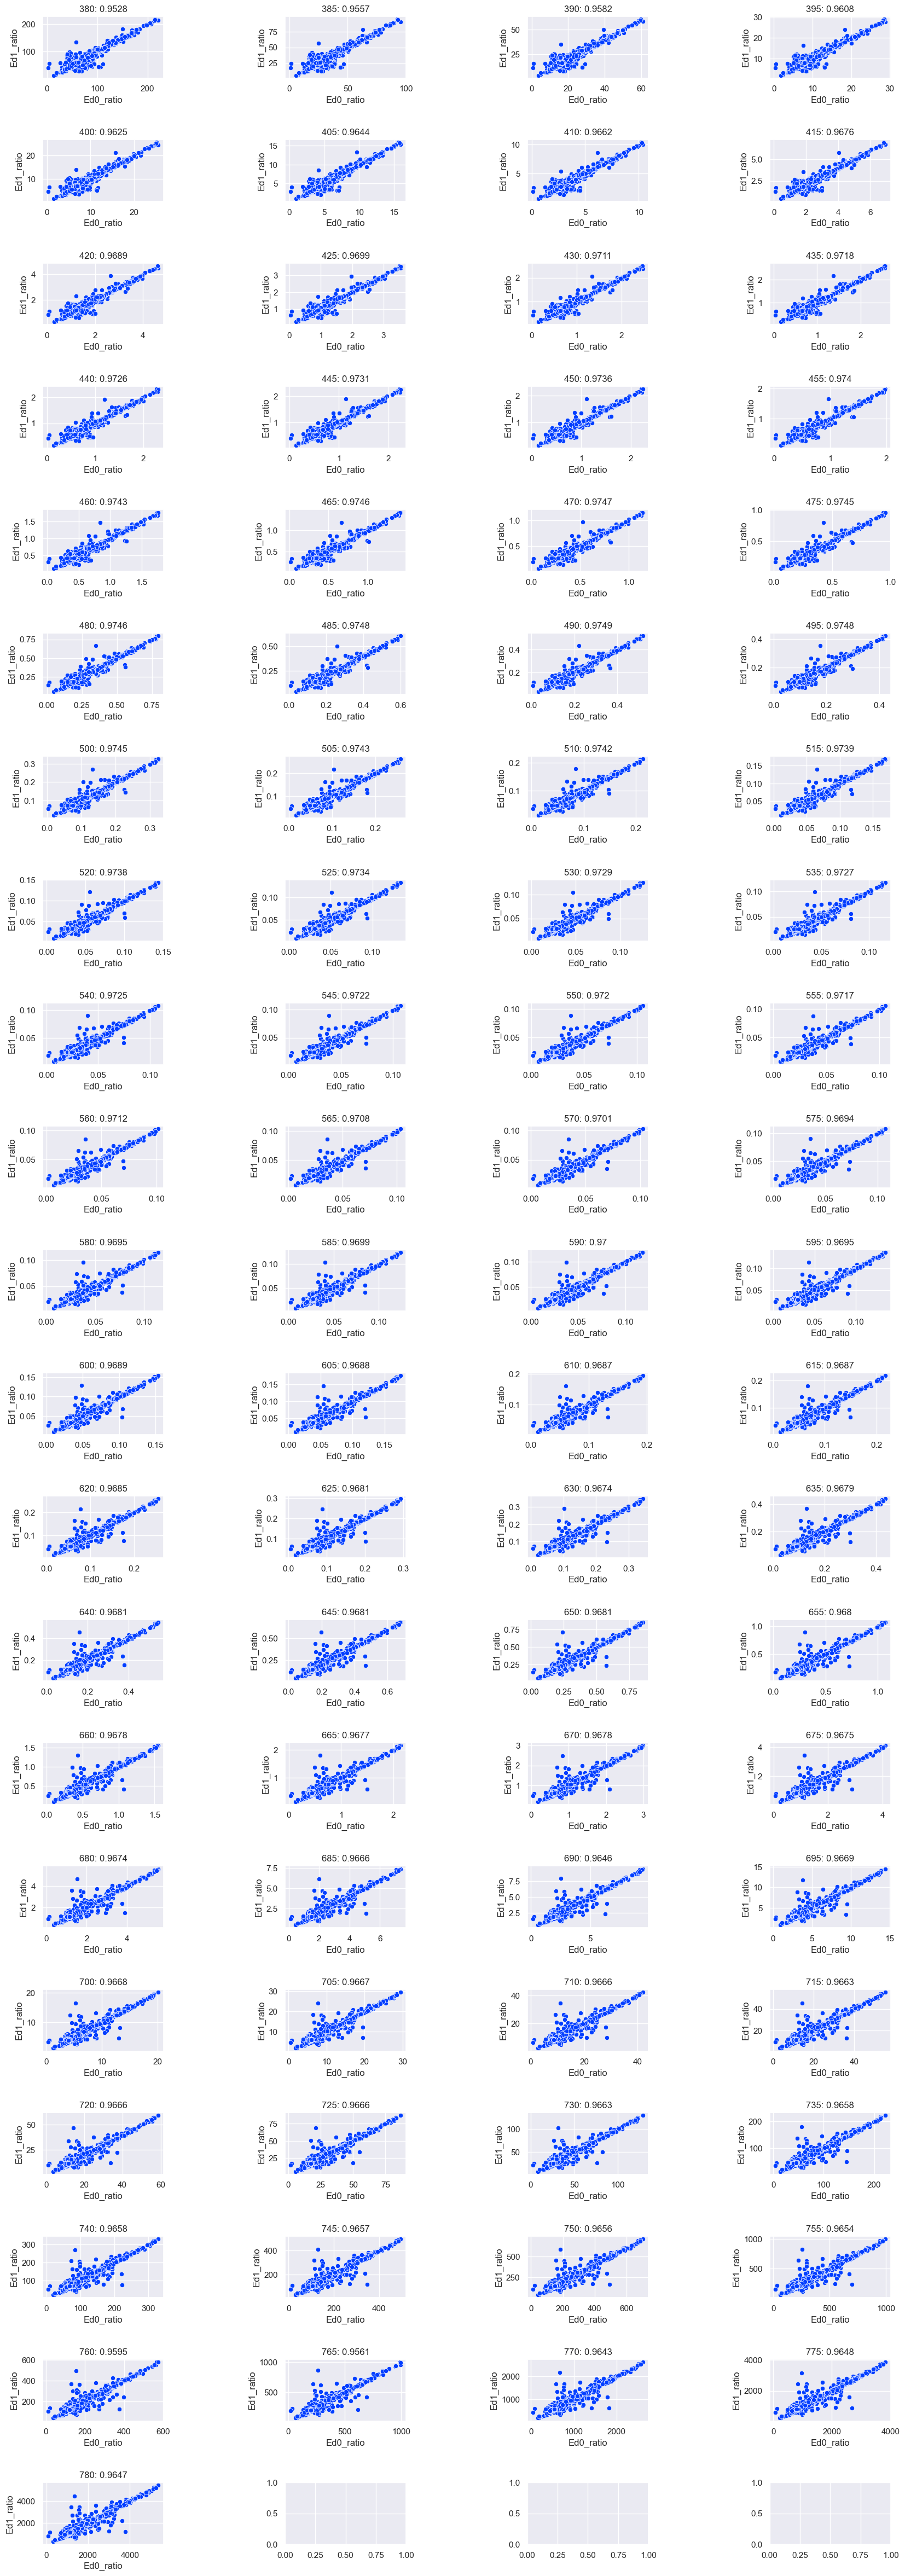

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the Seaborn theme
sns.set_theme(style="darkgrid", palette="bright")

# List of names
names = list(df1.columns)

# Fixed column names
column_names = ["Ed0_ratio", "Ed1_ratio"]

# Calculate the number of rows and columns based on the number of names
num_names = len(names)
num_cols = 4
num_rows = -(-num_names // num_cols)  # Ceiling division

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 60))
plt.subplots_adjust(wspace=1, hspace=1)

# Create an iterator from the list of names
name_iterator = iter(names)

# Iterate through subplots and names
for i in range(num_rows):
    for j in range(num_cols):
        try:
            name = next(name_iterator)
        except StopIteration:
            break

        ax = axs[i, j]

        # Create the scatterplot
        sns.scatterplot(x=Ed0_photodiode_ratio_same_shape[name], y=Ed1_photodiode_ratio_same_shape[name], ax=ax)
        ax.set_title(f"{name}: {round(pd.DataFrame(correlation).loc[name,0],4)}")
        ax.set_xlabel(column_names[0])
        ax.set_ylabel(column_names[1])
        #ax.set_xscale('log')
        #ax.set_yscale('log')